In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from specimens import PSQTFactorisation
from evolution import Evolution
import seaborn as sns
import matplotlib.pyplot as plt
from psqt import *
from utils import *
import sqlite3
from sklearn.metrics import mean_squared_error as mse

In [3]:
dbfile = './fen/test.db'
con = sqlite3.connect(dbfile)
cur = con.cursor()
fen_list = np.array([entry[0] for entry in cur.execute("SELECT fen FROM evaluations LIMIT 500000")])

In [4]:
mean_raw_values = np.round(np.mean(raw_pesto_psqt, axis=0))
pesto_piece_values_matrix = np.tile(pesto_piece_values + mean_raw_values, 64).reshape(64, 12)
pesto_piece_values_matrix = np.round(pesto_piece_values_matrix / 9) * 9 
new_raw_values = pesto_psqt - pesto_piece_values_matrix

PSQTFactorisation.use_target_psqts(np.round(new_raw_values / 1) * 1 + pesto_piece_values_matrix)
PSQTFactorisation.use_piece_values(pesto_piece_values_matrix)

In [5]:
def get_evolution(seed=None, generation_size=20):
    e = Evolution(
    PSQTFactorisation, 
    generation_size=generation_size, 
    top_k=1, 
    allow_crossover=False, 
    mutation_args={'p_weight': 0.005, 'p_component': 0.002, 'm_component': 1, 'm_weight': 3},
    init_args={'n_components': 0,
               'cw_ratio': 1, 
               'component_range': [0, 1], 
               'weight_range': [-128, 127], 
               'integer_weights': True, 
               'loss_fn': 'mse'})
    if seed is None:
        return e
    
    all_specimens = np.array([seed.copy() for _ in range(generation_size)])
    for s in all_specimens:
        s.mutate(p_weight=0.1, p_component=0.1, m_weight=20)
    all_specimens[0] = seed.copy()
    e.all_specimens = all_specimens
    return e


def add_component(s, max_components):
    if s.n_components >= max_components:
        return
    s.n_components = s.n_components + 1
    s.n_weights = s.n_weights + 1
    s.genes['components'] = np.concatenate([s.genes['components'].T, np.zeros(shape=(1,64))]).T
    s.genes['weights'] = np.concatenate([s.genes['weights'], np.zeros(shape=(1,12))])

In [38]:
# components = np.load('results/trial7/c14.npy')
# weights = np.load('results/trial7/w14.npy')
# seed = PSQTFactorisation(n_components=14, component_range=[0,1], weight_range=[-128, 127], integer_weights=True,
#                          genes={'components': components, 'weights': weights})
# best=seed
# print(seed.evaluate())
# print(components.shape)

# evolution = get_evolution(seed)

-59.35546875
(64, 14)


In [6]:
wdl_true = get_wdl(pesto_psqt, fen_list)

In [ ]:
N = 1
evolutions = []
best_score = -1000000
best_evolution = None
for trial in range(N):
    evolution = get_evolution()
    last_best_score = -1000000
    for iteration in range(10):
        for s in evolution.all_specimens:
            add_component(s, iteration + 1)
        current_best_score = evolution.simulate(100, print_interval=100)[-1]
        while current_best_score - last_best_score > 0.1 / (trial + 1):
            last_best_score = current_best_score
            current_best_score = evolution.simulate(500, print_interval=100)[-1] 
    b, e = evolution.get_best_specimen()

    wdl_hat = get_wdl(b.get_phat(), fen_list)
    score = -mse(wdl_true, wdl_hat)
    evolutions.append((evolution, score))
    if score > best_score:
        best_score = score
        best_evolution = evolution

evolution = best_evolution
fh = evolution.fitness_history
best, _ = evolution.get_best_specimen()
print(best_score)

In [ ]:
# for s in evolution.all_specimens:
#     s.n_components = s.n_components + 1
#     s.n_weights = s.n_weights + 1
#     s.genes['components'] = np.concatenate([s.genes['components'].T, np.zeros(shape=(1,64))]).T
#     s.genes['weights'] = np.concatenate([s.genes['weights'], np.zeros(shape=(1,12))])
#     # s.loss_fn = 'mse'
# evolution.all_specimens[0].evaluate()

In [ ]:
# iterations = 1
# for i in range(iterations):
#     # PSQTFactorisation.use_fens(np.random.choice(fen_list, 1_000, replace=False))
#     print(f"Iteration: {i+1}\t", end="")
#     fh = evolution.simulate(5_000, print_interval=100)

In [ ]:
sns.lineplot((np.abs(fh)))

In [39]:
best.genes['components'].shape
best.genes['weights'].min()

(64, 14)

In [55]:
diff = np.abs(best.get_phat() - pesto_psqt) * np.minimum(1, importance_mask)

print(f"Max:\t{diff.max()}")
print(f"MAE:\t{diff.mean()}")
print(f"ME:\t{np.mean((best.get_phat() - pesto_psqt) * np.minimum(1, importance_mask))}")
print(f"MSE:\t{np.mean(np.square((best.get_phat() - pesto_psqt) * np.minimum(1, importance_mask)))}")
print(f"MRE:\t{np.mean(diff / pesto_psqt)}")

Max:	30.0
MAE:	5.787760416666667
ME:	-0.08463541666666667
MSE:	59.35546875
MRE:	0.020702883722238576


In [43]:
np.mean(diff.flatten() < 20)

0.9791666666666666

<Axes: ylabel='Count'>

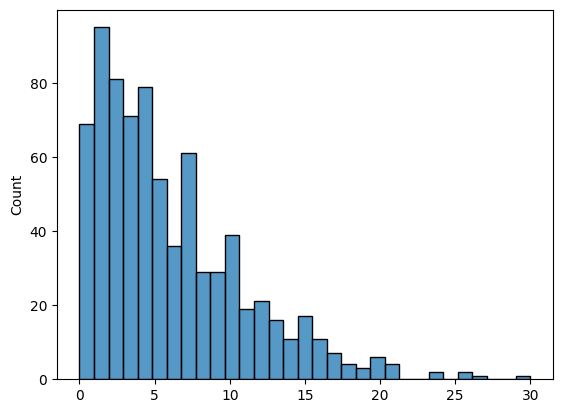

In [44]:
sns.histplot(diff.flatten(), bins=int(diff.max() + 1))

In [32]:
# np.save('results/trial11/c12.npy', best.genes['components'])
# np.save('results/trial11/w12.npy', best.genes['weights'])

In [45]:
def plot_all_components(specimen):
    n_components = specimen.genes['components'].shape[1]
    n_rows = max(2, np.ceil(n_components / 4).astype(np.int32))
    fig, axs = plt.subplots(n_rows, 4)
    for row in range(n_rows):
        for col in range(4):
            if row * 4 + col >= n_components:
                continue
            axs[row, col].tick_params(left=False, bottom=False)
            sns.heatmap(specimen.genes['components'][:,row*4+col].reshape(8,8), ax=axs[row,col], cbar=False, vmin=0, vmax=best.genes['components'].max())
def plot_all_diff(psqt, target, n_tables=12):
    fig, axs = plt.subplots(n_tables//4, 4)
    fig.figsize=(16, 12)
    for row in range(n_tables//4):
        for col in range(4):
            axs[row, col].tick_params(left=False, bottom=False)
            sns.heatmap((psqt[:,row*4+col] - target[:,row*4+col]).reshape(8,8),ax=axs[row,col], cmap='icefire', center=0, vmin=-20, vmax=20)
            axs[row, col].set(xticklabels=[])
            axs[row, col].set(yticklabels=[])
def plot_all_tables(psqt):
    n_tables = 12
    fig, axs = plt.subplots(n_tables//4, 4)
    fig.figsize=(16, 12)
    for row in range(n_tables//4):
        for col in range(4):
            axs[row, col].tick_params(left=False, bottom=False)
            sns.heatmap((psqt[:,row*4+col]).reshape(8,8), ax=axs[row,col], cbar=False)
            axs[row, col].set(xticklabels=[])
            axs[row, col].set(yticklabels=[])
            # axs[row, col].legend([], [], frameon=False)

In [ ]:
plot_all_tables(pesto_psqt)

In [ ]:
plot_all_tables(best.get_phat())

In [ ]:
plot_all_diff(best.get_phat(), pesto_psqt)

In [ ]:
sns.histplot(best.genes['weights'].flatten())

In [ ]:
plot_all_components(best)